# Modeling 111011001 - all features

In this notebook, we're specifically working on the dataset formed by dropping (31, 496, 524, 692, 917, 1299) with all features.

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy import optimize

pd.set_option('display.precision',20)
pd.set_option('display.max_colwidth',100)

from sklearn import linear_model, svm, tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.neural_network import MLPRegressor
    
    
    
import xgboost as xgb

from time import time
from scipy.stats import randint as sp_randint

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

In [2]:
# def to compare goodness of fit on training set
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
# run randomized search
def random_search(regr, param_dist, n_iter_search): 
    rs = RandomizedSearchCV(regr, param_distributions=param_dist, scoring = 'neg_mean_squared_error',
                                   n_jobs=-1, n_iter=n_iter_search, cv=kfold) #, verbose = 4)
    start = time()
    rs.fit(x_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
    report(rs.cv_results_)

In [5]:
# run single parameter search (for ridge or lasso)
def single_search(regr, params):
    regr_results_df = pd.DataFrame(dtype = 'float64')
    count = 0
    for k, v in params.items():
        for val in v:
            regr.set_params(**{k: val})
            regr_results_df.loc[count, k] = val
            results = cross_val_score(regr, x_train, y_train, cv=kfold, scoring = 'neg_mean_squared_error')
            (regr_results_df.loc[count, 'RMSE'], regr_results_df.loc[count, 'std dev']) = \
                    (np.sqrt(-results.mean()), np.sqrt(results.std()))
            count += 1
    return regr_results_df

In [6]:
# test against validation set
def validate(regr):
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_validation)
    return rmse(y_validation, y_pred)

In [7]:
# Cross-validation sets
kfold = KFold(n_splits=10, random_state=7)

In [8]:
df = pd.read_csv("./input/train_tidy_111011001.csv")

In [9]:
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=71)

X = df.values

for train_idx, validation_idx in ss.split(X):
    train_df = df.iloc[train_idx]
    validation_df = df.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values

## Ridge regression

In [10]:
ridge_regr = linear_model.Ridge()

In [11]:
ridge_param = {'alpha': scipy.stats.expon(scale=10)}
random_search(ridge_regr, ridge_param, 20)

RandomizedSearchCV took 3.32 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.013 (std: 0.005)
Parameters: {'alpha': 13.982567582724801}

Model with rank: 2
Mean validation score: -0.013 (std: 0.005)
Parameters: {'alpha': 8.7493987399393802}

Model with rank: 3
Mean validation score: -0.013 (std: 0.005)
Parameters: {'alpha': 15.105582405973152}



alpha                    RMSE                 std dev
0     5.0  0.11278133847711423188  0.06853616402693260556
1     6.0  0.11249279817622226396  0.06841155196638716574
12   17.0  0.11229131750839213555  0.06832092936356762292
2     7.0  0.11228886477902982888  0.06832350252172579574
11   16.0  0.11220343393860132686  0.06828825875784115540
3     8.0  0.11214835236677127284  0.06826378337851791989
10   15.0  0.11212738693194745920  0.06825911046193880449
9    14.0  0.11206499891858147377  0.06823435567017388514
4     9.0  0.11205704506825768518  0.06822609429165744921
8    13.0  0.11201848140228698458  0.06821507941568991096
5    10.0  0.11200491091756031858  0.06820564263517557568
7    12.0  0.11199055171262384256  0.06820264267982531492
6    11.0  0.11198459703166104007  0.06819876594444018725

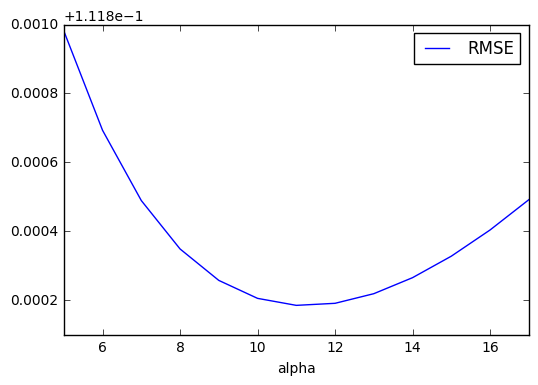

In [34]:
ridge_params = {'alpha': np.arange(5, 18, 1).tolist()}
ridge_df = single_search(ridge_regr, ridge_params)
ridge_df.plot(x = ['alpha'], y = ['RMSE'])
ridge_df.sort_values(['RMSE'], ascending = False)

In [40]:
ridge_regr = linear_model.Ridge(alpha = 11)

In [41]:
validate(ridge_regr)

0.11110292765605044

## Lasso

In [15]:
lasso_regr = linear_model.Lasso(max_iter=50000)

In [16]:
lasso_param = {'alpha': scipy.stats.expon(scale=0.001)}
random_search(lasso_regr, lasso_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RandomizedSearchCV took 178.49 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00046188433636357878}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00033804434871051681}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.0003244325169258025}



alpha                    RMSE                 std dev
0  0.00010000000000000000  0.11276443200820787660  0.06800283487371905355
1  0.00020000000000000001  0.11001218398187058434  0.06775353309150637660
5  0.00060000000000000006  0.10951599927964252024  0.06658498472218291053
2  0.00030000000000000003  0.10913412910279023105  0.06693867568217280739
4  0.00050000000000000001  0.10895701635544378927  0.06631786559661977110
3  0.00040000000000000002  0.10893109057640841530  0.06639091020231868701

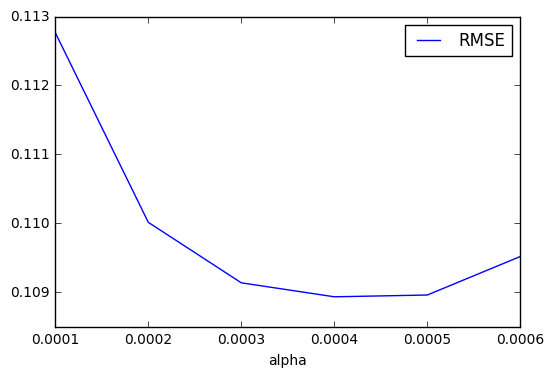

In [35]:
lasso_params = {'alpha': np.arange(0.0001, 0.0007, 0.0001).tolist()}
lasso_df = single_search(lasso_regr, lasso_params)
lasso_df.plot(x = ['alpha'], y = ['RMSE'])
lasso_df.sort_values(['RMSE'], ascending = False)

In [42]:
lasso_regr = linear_model.Lasso(alpha=0.0004, max_iter=50000)

In [43]:
validate(lasso_regr)

0.10456894564010284

## Lasso LARS

In [18]:
lassolars_regr = linear_model.LassoLars(max_iter=50000)

In [19]:
lassolars_param = {'alpha': scipy.stats.expon(scale=0.0001)}
random_search(lassolars_regr, lassolars_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 124 iterations, i.e. alpha=1.059e-04, with an active set of 102 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 125 iterations, i.e. alpha=1.055e-04, with an active set of 103 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 138 iterations, alpha=8.070e-05, previous alpha=8.019e-05, with an active set of 115 regressors.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/skl

RandomizedSearchCV took 9.60 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 9.7752479825515836e-05}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00010975367870815882}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 6.9274564007961226e-05}



alpha                    RMSE                 std dev
0  0.00006000000000000000  0.10861094794136062769  0.06648048091570869789
1  0.00007000000000000001  0.10806956048223632927  0.06634093732591093973
7  0.00013000000000000004  0.10797342225355441303  0.06660424019806045204
6  0.00012000000000000004  0.10780086232018193382  0.06651192291003760193
2  0.00008000000000000002  0.10775460793745565702  0.06621854355298824324
5  0.00011000000000000003  0.10766039297931349894  0.06641097272602761170
3  0.00009000000000000002  0.10757877305340057816  0.06618406147414017393
4  0.00010000000000000002  0.10756913895721420538  0.06628514203027958962

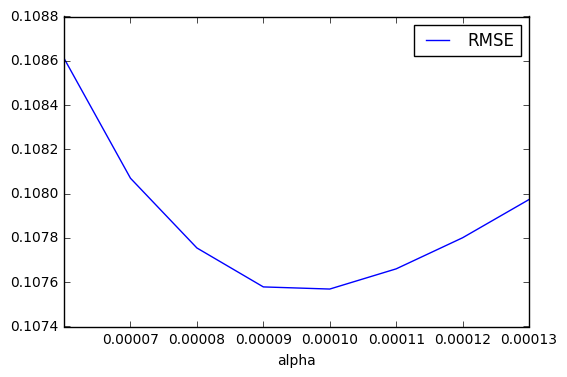

In [36]:
lassolars_params = {'alpha': np.arange(0.00006, 0.00014, 0.00001).tolist()}
lassolars_df = single_search(lassolars_regr, lassolars_params)
lassolars_df.plot(x = ['alpha'], y = ['RMSE'])
lassolars_df.sort_values(['RMSE'], ascending = False)

In [44]:
lassolars_regr = linear_model.LassoLars(alpha=0.0001, max_iter=50000)

In [45]:
validate(lassolars_regr)

0.10163414796915478

## Elastic Net

In [21]:
elnet_regr = linear_model.ElasticNet(max_iter=15000, random_state=7)

In [22]:
elnet_param =  {'alpha': scipy.stats.expon(scale=0.001), 'l1_ratio': scipy.stats.truncnorm(0, 1, loc=0.5, scale=0.25)}
random_search(elnet_regr, elnet_param, 20)

RandomizedSearchCV took 25.49 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00051772852125632929, 'l1_ratio': 0.74546220429086041}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00065045476361525704, 'l1_ratio': 0.60224672562101778}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.0007803596061589517, 'l1_ratio': 0.60742767523961272}



alpha                    RMSE                 std dev
0  0.00029999999999999997  0.11104595038939174545  0.06765784085225574895
1  0.00039999999999999996  0.11028733670309411041  0.06751380722654559685
2  0.00050000000000000001  0.10983199377288019316  0.06726649475938729916
3  0.00059999999999999995  0.10962936996461744577  0.06696151839067156220
7  0.00099999999999999980  0.10960270001514335614  0.06660155655686382514
4  0.00069999999999999988  0.10954537757330833070  0.06671012853037137924
6  0.00089999999999999998  0.10954140451227016573  0.06650036063802088060
5  0.00079999999999999993  0.10952605106390704559  0.06656106359014475615

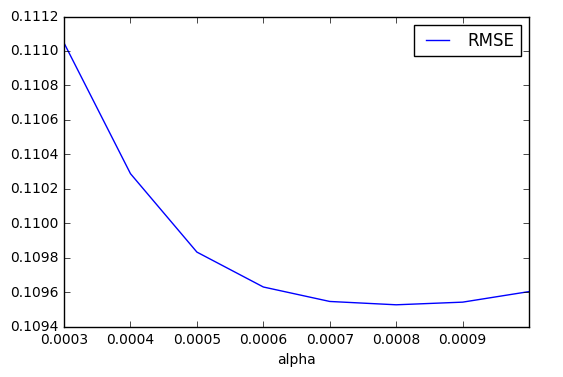

In [37]:
elnet_regr = linear_model.ElasticNet(alpha=0.00038, l1_ratio=0.5, max_iter=15000, random_state=7)
elnet_params = {'alpha': np.arange(0.0003, 0.001, 0.0001).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['alpha'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

l1_ratio                    RMSE                 std dev
0  0.10000000000000000555  0.11237649105537367289  0.06800429844727311213
1  0.20000000000000001110  0.11081067014071542542  0.06720763391946484033
8  0.90000000000000002220  0.11051852573351927944  0.06705439282974440252
2  0.30000000000000004441  0.11008804221729460993  0.06717082643040371559
7  0.80000000000000004441  0.11005732406117531286  0.06690325032680120854
3  0.40000000000000002220  0.10967042737295976118  0.06679088294897636557
6  0.70000000000000006661  0.10964867737182594498  0.06661516856118950003
4  0.50000000000000000000  0.10952605106390701784  0.06656106359014481166
5  0.59999999999999997780  0.10946193689476145516  0.06655511410672089456

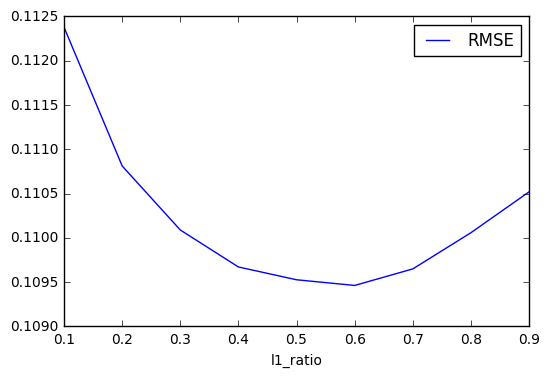

In [46]:
elnet_regr = linear_model.ElasticNet(alpha=0.0008, max_iter=15000, random_state=7)
elnet_params = {'l1_ratio': np.arange(0.1, 1, 0.1).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['l1_ratio'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

In [47]:
elnet_regr = linear_model.ElasticNet(alpha=0.0008, l1_ratio=0.6, max_iter=15000, random_state=7)

In [48]:
validate(elnet_regr)

0.10509218214025635

## Random Forest

In [24]:
rf_regr = RandomForestRegressor(n_jobs=-1, random_state = 7)

In [25]:
rf_param =  {'n_estimators': scipy.stats.randint(50,400), 'max_depth': scipy.stats.randint(2,20), 
             'max_features': scipy.stats.randint(5,30)}
random_search(rf_regr, rf_param, 20)

RandomizedSearchCV took 138.16 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.016 (std: 0.005)
Parameters: {'max_features': 28, 'n_estimators': 250, 'max_depth': 15}

Model with rank: 2
Mean validation score: -0.016 (std: 0.005)
Parameters: {'max_features': 23, 'n_estimators': 151, 'max_depth': 16}

Model with rank: 3
Mean validation score: -0.016 (std: 0.005)
Parameters: {'max_features': 23, 'n_estimators': 311, 'max_depth': 17}



n_estimators                    RMSE                 std dev
1          150.0  0.12397239242075266952  0.07035408202988852056
0          100.0  0.12382252938565468936  0.07006987735302326603
2          200.0  0.12375619974139372148  0.07057294947981053446
8          500.0  0.12368455331133579311  0.07125093975590772455
4          300.0  0.12364001037357028046  0.07069131582132284763
11         650.0  0.12363888475894317664  0.07140404069307729196
12         700.0  0.12362654564087695308  0.07138545076678490253
10         600.0  0.12361812819995922352  0.07150182155005829765
13         750.0  0.12361362848616699872  0.07137992701443565680
7          450.0  0.12361047098713776049  0.07110497389902126208
6          400.0  0.12360315079655757875  0.07106516277275777560
5          350.0  0.12357699327226187580  0.07121385838491578468
3          250.0  0.12356552991304016464  0.07067131991899604226
9          550.0  0.12356344025704385503  0.07125903705509513408

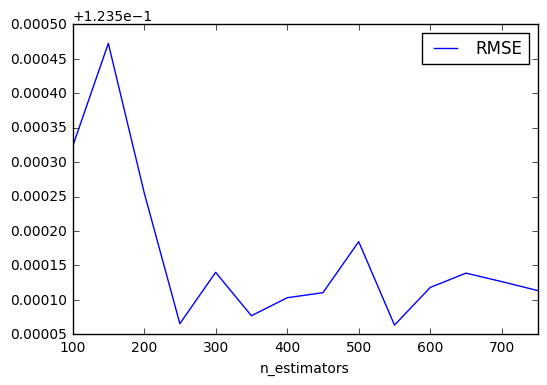

In [63]:
rf_regr = RandomForestRegressor(n_estimators = 250, max_depth = 15, max_features = 76, random_state = 7)
rf_params = {'n_estimators': np.arange(100, 800, 50).tolist()}
rf_df = single_search(rf_regr, rf_params)
rf_df.plot(x = ['n_estimators'], y = ['RMSE'])
rf_df.sort_values(['RMSE'], ascending = False)

In [68]:
rf_regr = RandomForestRegressor(n_estimators = 550, max_depth = 15, max_features = 76, random_state = 7)

In [69]:
validate(rf_regr)

0.12362621378678934

## Support Vector Regressor

In [27]:
svr_regr = svm.SVR(cache_size=200, degree=3, max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [28]:
svr_param = {'C': scipy.stats.expon(scale=1), 'gamma': scipy.stats.expon(scale=.1),
              'kernel': ['rbf']}
random_search(svr_regr, svr_param, 20)

RandomizedSearchCV took 48.49 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.015 (std: 0.005)
Parameters: {'kernel': 'rbf', 'C': 0.76687925477215324, 'gamma': 0.0028677416679831896}

Model with rank: 2
Mean validation score: -0.015 (std: 0.005)
Parameters: {'kernel': 'rbf', 'C': 0.57148810342129552, 'gamma': 0.016087600761929232}

Model with rank: 3
Mean validation score: -0.017 (std: 0.005)
Parameters: {'kernel': 'rbf', 'C': 2.7326895058837324, 'gamma': 0.029172881795096167}



C                    RMSE                 std dev
0   0.50000000000000000000  0.12016430634562631774  0.07021771020720510292
1   0.59999999999999997780  0.11919792046888538772  0.07001266646493670143
2   0.69999999999999995559  0.11855259969208170601  0.06979981328356844872
3   0.79999999999999993339  0.11803290758822607143  0.06977442102046256533
4   0.89999999999999991118  0.11764172022177898924  0.06956246092982072693
5   0.99999999999999988898  0.11740134966213192080  0.06939984338061372382
6   1.09999999999999986677  0.11722793235113619648  0.06937076833043254176
7   1.19999999999999973355  0.11708766157606621816  0.06925521633583532621
8   1.29999999999999982236  0.11700567184572346902  0.06919637601986747266
9   1.39999999999999991118  0.11688179795979128373  0.06899091346105284961
19  2.39999999999999946709  0.11684743129006289197  0.06768979211950101882
10  1.49999999999999977796  0.11673092011799643397  0.06868037301004362161
18  2.29999999999999982236  0.11668840593332145683  0.06777289868736274814
11  1.59999999999999964473  0.11659933730108244798  0.06841705808956566326
17  2.19999999999999973355  0.11657140682267022602  0.06782997206380426969
12  1.69999999999999973355  0.11649189568760279223  0.06823226577800321768
16  2.09999999999999964473  0.11646856919966924737  0.06789169946679779466
13  1.79999999999999982236  0.11643323004148045663  0.06807236286127231473
15  1.99999999999999955591  0.11640752506326323967  0.06792476947264623754
14  1.89999999999999968914  0.11639341613756593041  0.06797542813787059435

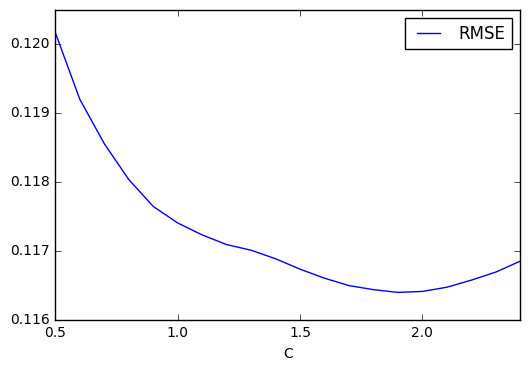

In [54]:
svr_regr = svm.SVR(C=0.77, cache_size=200, coef0=0.0, degree=3, gamma=0.008,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr_params = {'C': np.arange(0.5, 2.5, 0.1).tolist()}
svr_df = single_search(svr_regr, svr_params)
svr_df.plot(x = ['C'], y = ['RMSE'])
svr_df.sort_values(['RMSE'], ascending = False)

In [58]:
svr_regr = svm.SVR(C=1.9, cache_size=200, coef0=0.0, degree=3, gamma=0.008,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [59]:
validate(svr_regr)

0.11855223837146894

## Orthogonal Matching Pursuit

In [29]:
omp_regr = linear_model.OrthogonalMatchingPursuit()

In [30]:
omp_param = {'n_nonzero_coefs': scipy.stats.randint(20,120)}
random_search(omp_regr, omp_param, 20)

RandomizedSearchCV took 4.91 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.014 (std: 0.005)
Parameters: {'n_nonzero_coefs': 98}

Model with rank: 2
Mean validation score: -0.014 (std: 0.004)
Parameters: {'n_nonzero_coefs': 51}

Model with rank: 3
Mean validation score: -0.014 (std: 0.005)
Parameters: {'n_nonzero_coefs': 119}



n_nonzero_coefs                    RMSE                 std dev
0             70.0  0.11919225949144394983  0.06552697700814155701
1             71.0  0.11902847384456921587  0.06632449021110765897
3             73.0  0.11893458926071022452  0.06636990489224085799
2             72.0  0.11885408275825258551  0.06667220253129806096
4             74.0  0.11857110973436024715  0.06615122223281799663
8             78.0  0.11843636829306072866  0.06701307477167696425
7             77.0  0.11838964081958297525  0.06682682089990199525
5             75.0  0.11820348241062610117  0.06578867684573889985
9             79.0  0.11814074709012421793  0.06645688324226450838
6             76.0  0.11805941430843536200  0.06632654567633396170

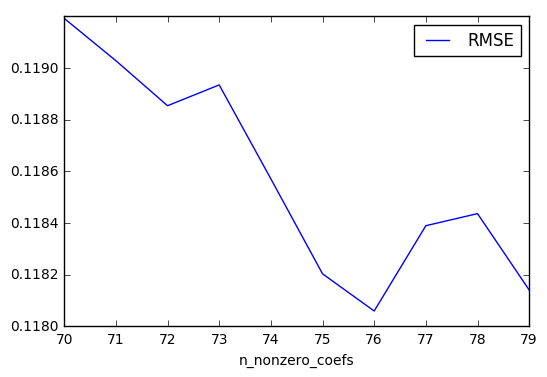

In [60]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=90)
omp_params = {'n_nonzero_coefs': np.arange(70, 80, 1).tolist()}
omp_df = single_search(omp_regr, omp_params)
omp_df.plot(x = ['n_nonzero_coefs'], y = ['RMSE'])
omp_df.sort_values(['RMSE'], ascending = False)

In [64]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=76)

In [65]:
validate(omp_regr)

0.1071864875558865

## XGBoost

In [31]:
xgb_regr = xgb.XGBRegressor(seed = 42, nthread = -1, silent = 1)
xgb_param = {'max_depth': scipy.stats.randint(1,10), # Max. Depth [1,∞]
             'min_child_weight': scipy.stats.expon(scale=1), # Min. Child Weight [0,∞]
             'gamma': scipy.stats.expon(scale=1), # Minimum Split Loss, gamma [0,∞]
             'subsample': scipy.stats.uniform(0, 1), # Subsample Ratio of the training instance [0,1]
             'colsample_bytree': scipy.stats.uniform(0, 1), # Subsample Ratio of columns [0,1]
             'reg_alpha': scipy.stats.expon(scale=1), # L1 regularization, alpha [0,∞]
             'reg_lambda': scipy.stats.expon(scale=1), # L2 regularization, lambda [0,∞]
             'learning_rate': scipy.stats.uniform(0, 1), # Step size shrinkage (learning rate) [0,1]
             'n_estimators': scipy.stats.randint(50,500) # Number of boosted trees, n_estimators
            }
random_search(xgb_regr, xgb_param, 20)

RandomizedSearchCV took 5607.96 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.015 (std: 0.004)
Parameters: {'reg_alpha': 0.49084827815675031, 'colsample_bytree': 0.17328322844490851, 'learning_rate': 0.19491909759547488, 'min_child_weight': 0.83519826693179, 'n_estimators': 373, 'subsample': 0.47799437028403657, 'reg_lambda': 2.8595767669228707, 'max_depth': 4, 'gamma': 0.034859966200231199}

Model with rank: 2
Mean validation score: -0.017 (std: 0.005)
Parameters: {'reg_alpha': 0.076149888137664046, 'colsample_bytree': 0.34192002776157038, 'learning_rate': 0.57111397872513292, 'min_child_weight': 0.65754793849410131, 'n_estimators': 209, 'subsample': 0.46937011819146457, 'reg_lambda': 2.1059501502877023, 'max_depth': 1, 'gamma': 0.17254275557097479}

Model with rank: 3
Mean validation score: -0.017 (std: 0.005)
Parameters: {'reg_alpha': 0.90218067361183207, 'colsample_bytree': 0.69235957533408465, 'learning_rate': 0.14901035643833871, 'min_

n_estimators                    RMSE                 std dev
0         450.0  0.11488295327134608048  0.06700333481590663165
1         460.0  0.11487053365329000232  0.06676928327071877944
2         470.0  0.11473013899074983868  0.06692293253544796816
3         480.0  0.11467275571353161001  0.06711670887012687048
4         490.0  0.11467250437464214519  0.06721403424964177142
8         530.0  0.11459213228386004590  0.06744013756312812469
7         520.0  0.11459097898772317714  0.06736066011337812909
9         540.0  0.11448658274867984375  0.06735307329195919235
6         510.0  0.11447998300234235591  0.06739800287760629172
5         500.0  0.11444389389682142755  0.06727188178455383027

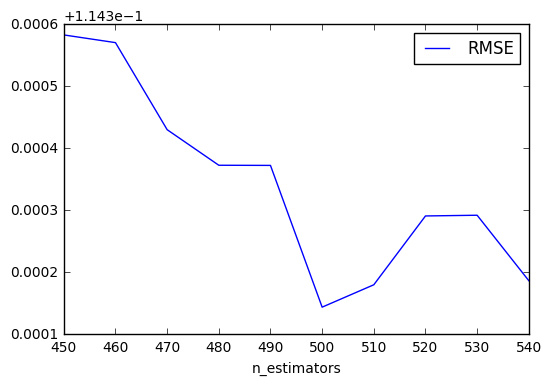

In [83]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 1, 
    min_child_weight = 4.1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.2,
    reg_alpha = 0.4,
    reg_lambda = 3.6, 
    learning_rate = 0.2,
    n_estimators = 373,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)
xgb_params = {'n_estimators': np.arange(450, 550, 10).tolist()}
xgb_df = single_search(xgb_regr, xgb_params)
xgb_df.plot(x = ['n_estimators'], y = ['RMSE'])
xgb_df.sort_values(['RMSE'], ascending = False)

In [84]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 1, 
    min_child_weight = 4.1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.2,
    reg_alpha = 0.4,
    reg_lambda = 3.6, 
    learning_rate = 0.2,
    n_estimators = 500,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)

In [85]:
validate(xgb_regr)

0.11482177352320572

## MLP Regressor

In [32]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(100, ),
                        alpha=0.0001, 
                        tol=0.0001, 
                        max_iter=200)

In [33]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641)
mlp_param = {'hidden_layer_sizes': scipy.stats.randint(50,500), # size of a single hidden layer
             'alpha': scipy.stats.expon(scale=0.0001), # L2 regularization,  [0,∞]
             'tol': scipy.stats.expon(scale=0.0001), # Minimum improvement in loss fun. during training
             'max_iter': scipy.stats.uniform(200, 400), # Maximum number of iterations of solver
            }
random_search(mlp_regr, mlp_param, 20)

RandomizedSearchCV took 1116.41 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.020 (std: 0.006)
Parameters: {'alpha': 0.00014500737478201074, 'max_iter': 436.85061273697551, 'tol': 0.00013282616746695567, 'hidden_layer_sizes': 476}

Model with rank: 2
Mean validation score: -0.021 (std: 0.004)
Parameters: {'alpha': 0.00011456338241808748, 'max_iter': 530.82768074649243, 'tol': 0.00010536242443869668, 'hidden_layer_sizes': 380}

Model with rank: 3
Mean validation score: -0.021 (std: 0.006)
Parameters: {'alpha': 2.6171255412647311e-05, 'max_iter': 470.28993166800132, 'tol': 5.4260998862774637e-05, 'hidden_layer_sizes': 476}



hidden_layer_sizes                    RMSE                 std dev
2                 3.0  0.13111229951379818615  0.07864116129780150677
7                 8.0  0.13104004914307804119  0.08399261046742731440
9                10.0  0.13065488714876680176  0.07499117506190763893
8                 9.0  0.12917128472393787919  0.07523847626792490306
4                 5.0  0.12886347316572244193  0.07576759784509058682
6                 7.0  0.12832893324223809683  0.07750067765578255718
5                 6.0  0.12685337482527403452  0.07644904246392320024
1                 2.0  0.12665651357392102017  0.07306659512465150941
3                 4.0  0.12264560727589764177  0.06770605610998044199
0                 1.0  0.11714245988831781253  0.06778818721227310162

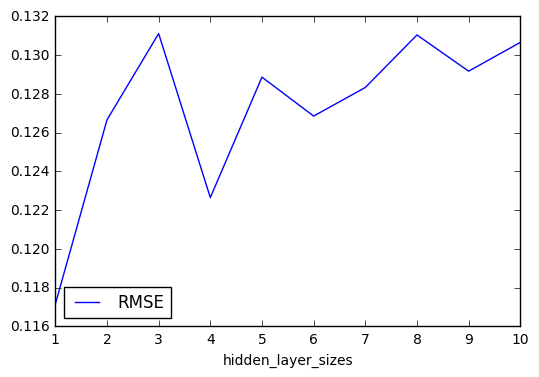

In [71]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(1, ),
                        alpha=0.0008, 
                        tol=0.0005, 
                        max_iter=200)
mlp_params = {'hidden_layer_sizes': np.arange(1, 11, 1).tolist()}
mlp_df = single_search(mlp_regr, mlp_params)
mlp_df.plot(x = ['hidden_layer_sizes'], y = ['RMSE'])
mlp_df.sort_values(['RMSE'], ascending = False)

In [73]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(1, ),
                        alpha=0.0008, 
                        tol=0.0005, 
                        max_iter=200)

In [74]:
validate(mlp_regr)

0.11348673136391933